In [1]:
import torch
import torch.nn as nn
import  torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os 
import time


c:\Users\ataka\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device config
#default cpu but we need GPU

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ",device) 

Device:  cuda:0


In [3]:
def read_images(path,num_img):
    array=np.zeros([num_img,64*32])
    i=0
    for img in os.listdir(path):
        img_path=path+"\\"+ img
        img=Image.open(img_path,mode="r")
        data=np.asarray(img,dtype="uint8")
        data=data.flatten()
        array[i,:]=data
        i+=1
    return array

In [4]:
#read train negative
train_negative_path=r"LSIFIR/Classification/Train/neg"
num_train_negative_img=43390
train_negative_array=read_images(train_negative_path,num_train_negative_img)

In [5]:
# pythorch array convert

x_train_negative_tensor=torch.from_numpy(train_negative_array)

y_train_negative_tensor=torch.zeros(num_train_negative_img,dtype=torch.long)

In [6]:
#read train positive
train_positive_path=r"LSIFIR/Classification/Train/pos/"
num_train_positive_img=10208
train_positive_array=read_images(train_positive_path,num_train_positive_img)

In [7]:
x_train_positive_tensor=torch.from_numpy(train_positive_array)

y_train_positive_tensor=torch.zeros(num_train_positive_img,dtype=torch.long)

In [8]:
#concat pos and neg

x_train=torch.cat((x_train_negative_tensor,x_train_positive_tensor),0)
print(x_train.size())
y_train=torch.cat((y_train_negative_tensor,y_train_negative_tensor),0)
y_train=y_train[:53598]
print(y_train.size())

torch.Size([53598, 2048])
torch.Size([53598])


In [9]:
print("X_train size",x_train.size())

X_train size torch.Size([53598, 2048])


In [10]:
# read test

test_negative_path=r"LSIFIR/Classification/Test/neg"
num_test_negative_img=22050
test_negative_array=read_images(test_negative_path,num_test_negative_img)
x_test_negative_tensor=torch.from_numpy(test_negative_array[:20855,:])
y_test_negative_tensor=torch.zeros(20855,dtype=torch.long)

test_positive_path=r"LSIFIR/Classification/Test/pos"
num_test_positive_img=5944
test_positive_array=read_images(test_positive_path,num_test_positive_img)
x_test_positive_tensor=torch.from_numpy(test_positive_array)
y_test_positive_tensor=torch.zeros(num_test_positive_img,dtype=torch.long)



In [11]:
x_test=torch.cat((x_test_negative_tensor,x_test_positive_tensor),0)
y_test=torch.cat((y_test_negative_tensor,y_test_positive_tensor),0)

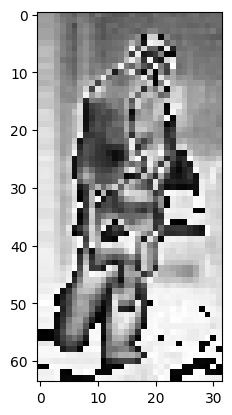

In [12]:
#visualize

plt.imshow(x_train[45001,:].reshape(64,32),cmap="gray")

# CNN
## HyperParameters

In [13]:

num_epochs=500
num_classes=2
batch_size=2000
learning_rate=0.00001

In [19]:
class Net(nn.Module):
    def __init__(self) :
        super(Net,self).__init__()

        self.con1=nn.Conv2d(1,10,5)
        self.pool=nn.MaxPool2d(2,2)
        self.con2=nn.Conv2d(10,16,5)

        #full connected layer
        self.fc1=nn.Linear(16*13*5,520)
        self.fc2=nn.Linear(520,130)
        self.fc2=nn.Linear(130,num_classes)

    def forward(self,x):
        x=self.pool(F.relu((self.con1(x))))
        x=self.pool(F.relu((self.con2(x))))
        print(x)
        x=x.view(-1,16*13*5)
        print(x)
        x=F.relu((self.fc1(x)))
        x=F.relu((self.fc2(x)))
        x=self.fc3(x)
        return x

In [20]:
import torch.utils.data
train=torch.utils.data.TensorDataset(x_train,y_train)
trainLoader=torch.utils.data.DataLoader(train,batch_size,shuffle=True)

test=torch.utils.data.TensorDataset(x_test,y_test)
testLoader=torch.utils.data.DataLoader(test,batch_size,shuffle=False)

In [21]:
net=Net().to(device)

# Loss and Optimizer

In [22]:
criterion =nn.CrossEntropyLoss()

import torch.optim as optim

optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=0.8)

In [18]:
# train network
start = time.time()
train_acc=[]
test_acc=[]
loss_list=[]

use_gpu=True

for epoch in range(num_epochs):
    for i,data in enumerate(trainLoader,0):
        print("Data is ",data)
        inputs,labels=data
        print("İnputs is",inputs)
        print("Labels are",labels)
        inputs=inputs.view(batch_size,1,64,32) #reshape
        inputs=inputs.float() # float
        
        #use gpu
        if use_gpu:
            if torch.cuda.is_available():
                inputs,labels=inputs.to(device),labels.to(device)
            
        #zero gradient
        optimizer.zero_grad()

        #forward
        outputs=net(inputs)
        
        #loss
        loss=criterion(outputs,labels)

        #back

        loss.backward()

        #update weights
        optimizer.step()

    # test
    correct=0
    total =0

    #no backprobagation
    with torch.no_grad():
        for data in testLoader:
            images,labels=data
            images=images.view(batch_size,1,64,32)
            images.float()

            #use gpu
            if use_gpu:
                if torch.cuda.is_available():
                    inputs,labels=inputs.to(device),labels.to(device)
            
            outputs=net(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct +=(predicted==labels).sum().item()

    acc1=correct/total
    print("Acc test:",acc1)
    test_acc.append(acc1)

    # train
    correct=0
    total =0

    with torch.no_grad():
        for data in trainLoader:
            images,labels=data
            images=images.view(batch_size,1,64,32)
            images.float()

            #use gpu
            if use_gpu:
                if torch.cuda.is_available():
                    inputs,labels=inputs.to(device),labels.to(device)
            
            outputs=net(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct +=(predicted==labels).sum().item()

    acc2=correct/total
    print("Acc train:",acc2)
    train_acc.append(acc2)

print("Train is done!")

end=time.time()
process_time = (end-start)/60
print("Process time :",process_time)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2000x520 and 130x2)